Escuchando...


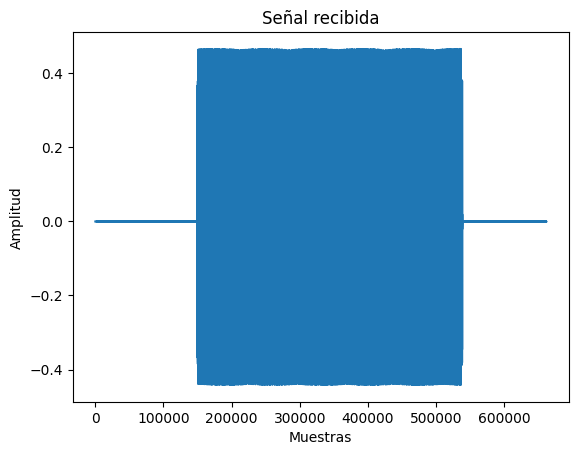

Bits re_cibidos: 0100010101110011011101000110010100100000011001010111001100100000 ...
Texto decodificado:
³ãËPöZåïí+LØ-Dfco1 prueba para la transmisión FSK utilizando modulación por desplazamiento de frecuencia.*×»Ë-ØþG­_¥5


In [ ]:
import numpy as np
import sounddevice as sd
from scipy.signal import butter, lfilter

fs = 44100
f0 = 1500
f1 = 2000
Tb = 0.01
samples_per_bit = int(fs*Tb)

# Filtro paso banda para mejorar detección
def bandpass(lowcut, highcut, data):
    b, a = butter(4, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    return lfilter(b, a, data)

def detect_bit(segment):
    seg0 = bandpass(1400, 1600, segment)
    seg1 = bandpass(1900, 2100, segment)
    
    e0 = np.sum(seg0**2)
    e1 = np.sum(seg1**2)

    return '1' if e1 > e0 else '0'

def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) == 8:
            chars.append(chr(int(byte, 2)))
    return ''.join(chars)
# recortar audio a su duracion
def receive(duration=10):
    print("Escuchando...")
    audio = sd.rec(int(duration*fs), samplerate=fs, channels=1)
    sd.wait()
    # Graficar lo recibido (opcional)
    import matplotlib.pyplot as plt
    
    audio = audio.flatten()
    # Pasar todo el audio por un filtro paso banda
    audio = bandpass(1400, 2100, audio)
    plt.plot(audio)
    plt.title("Señal recibida")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.show()
    bits = ""

    for i in range(0, len(audio), samples_per_bit):
        segment = audio[i:i+samples_per_bit]
        if len(segment) < samples_per_bit:
            break
        bits += detect_bit(segment)

    # Buscar preámbulo para sincronización
    preamble = "1010101010101010"
    idx = bits.find(preamble)
    if idx >= 0:
        bits = bits[idx+len(preamble):]

    print("Bits re_cibidos:", bits[:64], "...")
    print("Texto decodificado:")
    print(bits_to_text(bits))

receive(duration = 15)


In [18]:
import numpy as np
from IPython.display import Audio, display

# ==============================
# Parámetros de la modulación
# ==============================
fs = 44100       # Frecuencia de muestreo (Hz)
f0 = 1500        # Frecuencia para bit 0 (Hz)
f1 = 2000        # Frecuencia para bit 1 (Hz)
Tb = 0.01        # Duración de cada bit (s) -> 20 bits/s
A = 0.5          # Amplitud

# ==============================
# Utilidades
# ==============================

def text_to_bits(texto: str) -> str:
    """
    Convierte un texto en una cadena de bits (ASCII, 8 bits por carácter).
    """
    return ''.join(format(ord(c), '08b') for c in texto)

def generate_tone(bit: str) -> np.ndarray:
    """
    Genera el tono correspondiente a un bit ('0' o '1') durante Tb segundos.
    """
    t = np.linspace(0, Tb, int(fs * Tb), endpoint=False)
    freq = f1 if bit == '1' else f0
    return A * np.sin(2 * np.pi * freq * t)

def build_frame(mensaje: str) -> np.ndarray:
    """
    Construye el audio completo con:
    - Silencio inicial
    - Preámbulo de sincronización
    - Datos del mensaje
    - Silencio final
    """
    # Silencio inicial (0.5 s)
    silencio_ini = np.zeros(int(0.5 * fs))

    # Preámbulo
    preamble_bits = "1010101010101010"  # 16 bits alternados

    # Mensaje a bits
    data_bits = text_to_bits(mensaje)

    # Puedes añadir un marcador de fin si quieres:
    # end_bits = "00000000"
    # frame_bits = preamble_bits + data_bits + end_bits
    frame_bits = preamble_bits + data_bits

    # Generar señal FSK
    signal = np.concatenate([generate_tone(b) for b in frame_bits])

    # Silencio final (0.5 s)
    silencio_fin = np.zeros(int(0.5 * fs))

    # Concatenar todo
    audio = np.concatenate([silencio_ini, signal, silencio_fin])

    return audio

def transmit_display(mensaje: str):
    """
    Genera el audio FSK correspondiente al mensaje
    y lo muestra como un reproductor de audio en el notebook.
    """
    if not mensaje:
        print("Mensaje vacío, no se transmitirá nada.")
        return
    
    print(f"Mensaje a codificar en FSK: {mensaje}")
    audio = build_frame(mensaje)

    # Mostrar en el notebook
    display(Audio(audio, rate=fs))
    return audio  # por si quieres guardarlo o procesarlo luego
# Ejemplo de uso
# texto de 100 caracteres
audio_fsk = transmit_display("Este es un mensaje de prueba para la transmisión FSK utilizando modulación por desplazamiento de frecuencia.")


Mensaje a codificar en FSK: Este es un mensaje de prueba para la transmisión FSK utilizando modulación por desplazamiento de frecuencia.
